In [34]:
import requests

def get_weather_data(api_key, city_id):
    api_url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        "id": city_id,
        "units": "metric",
        "appid": api_key
    }
    response = requests.get(api_url, params=params)
    data = response.json()
    return data

api_key = "5a5dc4c0a633d9df1f1fd24f47b52ea0"
city_id = "1259931"
weather_data = get_weather_data(api_key, city_id)

print(f"City: {weather_data['name']}")
print(f"Temperature: {weather_data['main']['temp']}°C")

City: Pen
Temperature: 21.91°C


In [35]:
import requests

# API setup
API_KEY = "5a5dc4c0a633d9df1f1fd24f47b52ea0"
LOCATION = "Pen,IN"  # Replace with your city
URL = f"http://api.openweathermap.org/data/2.5/weather?q={LOCATION}&appid={API_KEY}"

# Fetch data
response = requests.get(URL)
if response.status_code == 200:
    weather_data = response.json()
    precipitation = weather_data.get("rain", {}).get("1h", 0)  # Rain in mm
    wind_speed = weather_data["wind"]["speed"]  # m/s
    print(f"Precipitation: {precipitation} mm\nWind Speed: {wind_speed} m/s")
else:
    print("Failed to fetch data. Status Code:", response.status_code)


Precipitation: 0 mm
Wind Speed: 2.06 m/s


In [36]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Example historical data (for demonstration)
# Replace with actual historical data
historical_data = {
    "temperature": [20, 25, 30, 22, 28],  # Example temperature data in Celsius
    "energy_consumption": [3000, 3500, 4000, 3200, 3800]  # Example energy consumption in Watts
}

# Convert data to numpy arrays
X = np.array(historical_data["temperature"]).reshape(-1, 1)  # Reshape for single feature
y = np.array(historical_data["energy_consumption"])
# binning for values 
# Train the model
model = LinearRegression()
model.fit(X, y)

# Predict energy demand for current temperature
current_temperature = weather_data["main"]["temp"]
predicted_demand = model.predict([[current_temperature]])[0]

print(f"Predicted Energy Demand: {predicted_demand} W")


Predicted Energy Demand: 30505.999999999996 W


In [37]:
def estimate_solar_power(cloud_cover, panel_area=1.0, efficiency=0.2):
    # Estimate solar radiation based on cloud cover
    solar_radiation = (1 - cloud_cover / 100) * 1000  # W/m^2
    # Power = Radiation * Area * Efficiency
    power = solar_radiation * panel_area * efficiency  # W
    return power

def estimate_wind_power(wind_speed, turbine_area=1.0, efficiency=0.4):
    # Power = 0.5 * air_density * area * wind_speed^3 * efficiency
    air_density = 1.225  # kg/m^3
    power = 0.5 * air_density * turbine_area * (wind_speed ** 3) * efficiency  # W
    return power

def estimate_hydropower(flow_rate, head_height, efficiency=0.85):
    density_water = 1000  # kg/m^3
    g = 9.81  # m/s^2
    power = density_water * g * flow_rate * head_height * efficiency
    return power

if weather_data:
    # Extract data
    precipitation = 90 #weather_data.get("rain", {}).get("1h", 0)  # Rainfall in mm (last hour)
    wind_speed = weather_data["wind"]["speed"]  # Wind speed in m/s (example usage)
    
    # Approximate flow rate (based on rainfall; adjust based on location)
    # Example: 1 mm of rainfall over 1 km² = 1 cubic meter per second
    area = 5  # km² (catchment area for rainfall)
    flow_rate = (precipitation / 1000) * area * 1e6 / 3600  # Convert mm/hour to m³/s
    
    # Assume constant head height (example: 20 m)
    head_height = 100  # meters
    
    # Calculate hydropower
    hydropower = estimate_hydropower(flow_rate, head_height)

cloud_cover = weather_data["clouds"]["all"]
wind_speed = weather_data["wind"]["speed"]

solar_power = estimate_solar_power(cloud_cover)
wind_power = estimate_wind_power(wind_speed)
hydropower = estimate_hydropower(flow_rate, head_height)

print(f"Cloud cover:{cloud_cover}\nWind Speed:{wind_speed}")

print(f"Power generation\nSolar Power: {solar_power}\nWind Power:{wind_power}\nHydropower: {hydropower / 1e6:.2f} MW")


Cloud cover:80
Wind Speed:2.06
Power generation
Solar Power: 39.99999999999999
Wind Power:2.1417449200000003
Hydropower: 104.23 MW


Optimal Solar Power: 40.00 W
Optimal Wind Power: 2.14 W
Optimal Hydro Power: 257.86 W


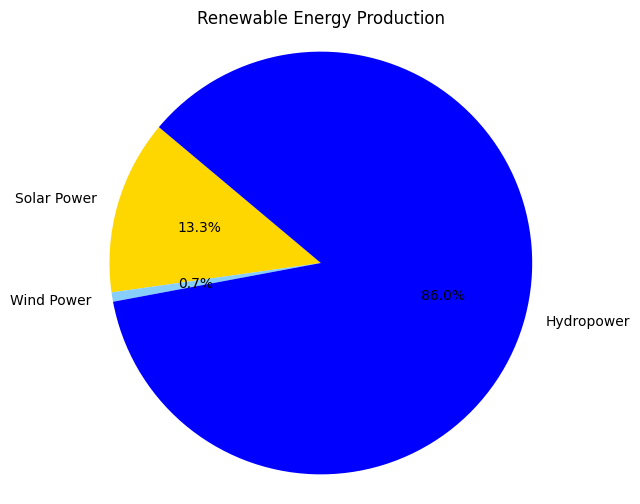

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Renewable energy production estimates (in Watts)
solar_power = estimate_solar_power(cloud_cover)
wind_power = estimate_wind_power(wind_speed)
hydropower = estimate_hydropower(flow_rate, head_height)

# Predicted demand in Watts
predicted_demand = 300

# Available capacities
capacities = np.array([solar_power, wind_power, hydropower])

# Initialize optimal power distribution
optimal_distribution = np.zeros_like(capacities)

# Distribute power to meet demand
remaining_demand = predicted_demand
for i in range(len(capacities)):
    if remaining_demand > 0:
        optimal_distribution[i] = min(capacities[i], remaining_demand)
        remaining_demand -= optimal_distribution[i]

# Extract optimal power values
optimal_solar_power, optimal_wind_power, optimal_hydro_power = optimal_distribution

# Output results
print(f"Optimal Solar Power: {optimal_solar_power:.2f} W")
print(f"Optimal Wind Power: {optimal_wind_power:.2f} W")
print(f"Optimal Hydro Power: {optimal_hydro_power:.2f} W")

# Plot renewable energy production
labels = ['Solar Power', 'Wind Power', 'Hydropower']
sizes = optimal_distribution
colors = ['gold', 'lightskyblue', 'blue']
explode = (0.1, 0.1, 0.1)  # Explode 1st and 2nd slices

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Renewable Energy Production')
plt.show()


In [39]:
import numpy as np
import pandas as pd
import random

# Number of data points (daily data for 365 days)
num_data_points = 365

# Generate timestamps
timestamps = pd.date_range(start="2025-01-01", periods=num_data_points, freq="D")

# Generate synthetic weather data
temperature = np.random.uniform(low=5, high=40, size=num_data_points)  # °C
humidity = np.random.uniform(low=30, high=90, size=num_data_points)    # %
wind_speed = np.random.uniform(low=0, high=15, size=num_data_points)   # m/s
solar_radiation = [
    max(0, 1000 * np.sin((np.pi / 12) * (hour % 24 - 6)))  # Simulate solar peak at noon
    for hour in range(num_data_points)
]

# Generate synthetic energy usage data
base_usage = 300  # Base load (kWh)
energy_usage = [
    base_usage +
    50 * (1 if 6 <= (hour % 24) < 18 else 0) +  # Daytime usage spike
    -10 * (temp > 30) + 10 * (temp < 15) +      # Temperature effects
    random.gauss(0, 50)                        # Random noise
    for hour, temp in enumerate(temperature)
]

# Create the dataset
data = {
    "Timestamp": timestamps,
    "Temperature (°C)": temperature,
    "Humidity (%)": humidity,
    "Wind Speed (m/s)": wind_speed,
    "Solar Radiation (W/m²)": np.random.uniform(50, 1000, num_data_points),
    "Energy Usage (kWh)": energy_usage
}

dataset = pd.DataFrame(data)

# Save to a CSV file
file_path = "data.csv"
dataset.to_csv(file_path, index=False)

file_path

'data.csv'

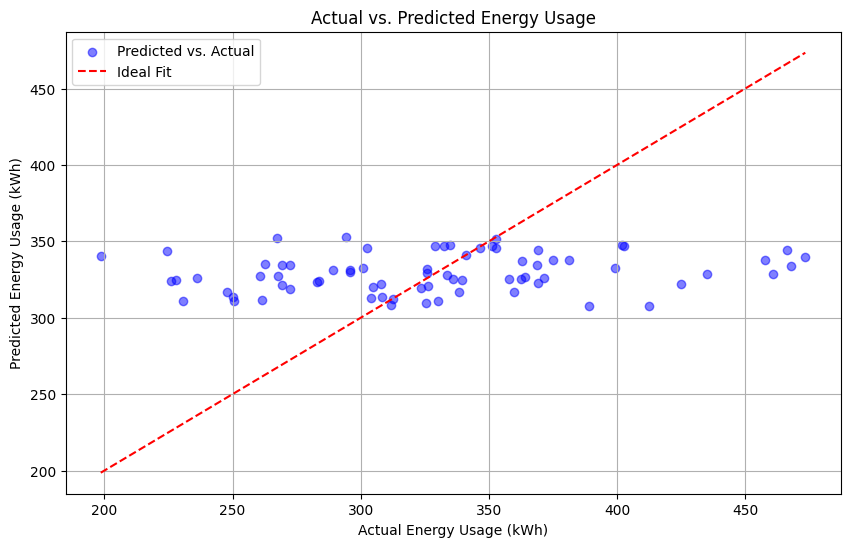

(3849.410323894789, 0.04011812173010598)

In [40]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv(file_path)

# Features and target variable
X = df[["Temperature (°C)", "Humidity (%)", "Wind Speed (m/s)", "Solar Radiation (W/m²)"]]
y = df["Energy Usage (kWh)"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot actual vs. predicted energy usage
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Energy Usage (kWh)")
plt.ylabel("Predicted Energy Usage (kWh)")
plt.title("Actual vs. Predicted Energy Usage")
plt.legend()
plt.grid(True)
plt.show()

# Display model evaluation metrics
mse, r2


Dataset Preview:
    Timestamp  Temperature (°C)  Humidity (%)  Wind Speed (m/s)  \
0  2025-01-01          8.198642     37.334102         12.765631   
1  2025-01-02         13.671003     80.698192          4.805542   
2  2025-01-03         34.516870     30.239078         11.013939   
3  2025-01-04         35.929817     54.083309          2.607099   
4  2025-01-05         26.184016     59.324268          9.909390   

   Solar Radiation (W/m²)  Energy Usage (kWh)  
0              639.858748          267.210799  
1              219.335980          228.607569  
2              925.098426          308.446819  
3              268.183634          311.942573  
4              659.208033          206.395733  

Actual vs Predicted Energy Consumption:
       Actual   Predicted
0  262.640886  336.395314
1  402.680723  349.740613
2  435.001117  328.267935
3  300.718702  331.372538
4  412.373702  306.346521


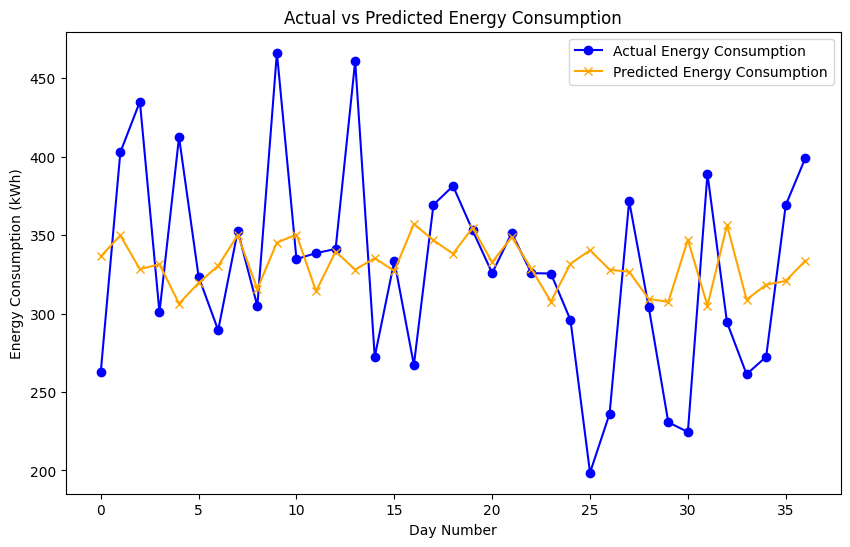


Model Performance Metrics:
Mean Squared Error (MSE): 4222.36
R² Score: -0.05


In [41]:
# Import Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the Dataset
data = pd.read_csv('data.csv')  # Replace with your dataset's path

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

# Check for missing values and handle them (if any)
if data.isnull().sum().any():
    print("\nMissing values detected. Filling with mean values...")
    data.fillna(data.mean(), inplace=True)

# Prepare Data for Modeling
# Define features (X) and target variable (y)
X = data[['Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)', 'Solar Radiation (W/m²)']]  # Features
y = data['Energy Usage (kWh)']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the Model
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
predictions = model.predict(X_test)

# Combine actual and predicted values for comparison
results = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': predictions})

# Display the first few rows of results
print("\nActual vs Predicted Energy Consumption:")
print(results.head())

# Visualize the Results
plt.figure(figsize=(10, 6))
plt.plot(results['Actual'], label='Actual Energy Consumption', color='blue', marker='o')
plt.plot(results['Predicted'], label='Predicted Energy Consumption', color='orange', marker='x')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Day Number')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()

# Calculate and print performance metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\nModel Performance Metrics:")
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R² Score: {r2:.2f}')


         date  temperature   humidity  rainfall  wind_speed day_type  \
0  2018-01-01    26.236204  57.121149       0.1    8.183652  Weekday   
1  2018-01-02    43.521429  22.936586       0.0    6.587585  Weekday   
2  2018-01-03    36.959818  87.794214       0.1   13.867551  Weekday   
3  2018-01-04    32.959755  75.909993       0.0   15.324909  Weekend   
4  2018-01-05    19.680559  40.497543       0.0    6.081893  Weekday   

  month_name  consumption  
0    January   108.761866  
1    January    69.784364  
2    January   113.168115  
3    January    99.441498  
4    January   119.203466  
Model Performance:
Linear Regression -> MSE: 113.55, R²: 0.74
Ridge Regression -> MSE: 113.53, R²: 0.74
Lasso Regression -> MSE: 115.43, R²: 0.74
Random Forest -> MSE: 123.42, R²: 0.72
Best Ridge Alpha: {'alpha': 1.0}
Best Lasso Alpha: {'alpha': 0.1}
Polynomial Ridge Regression -> MSE: 116.60, R²: 0.73


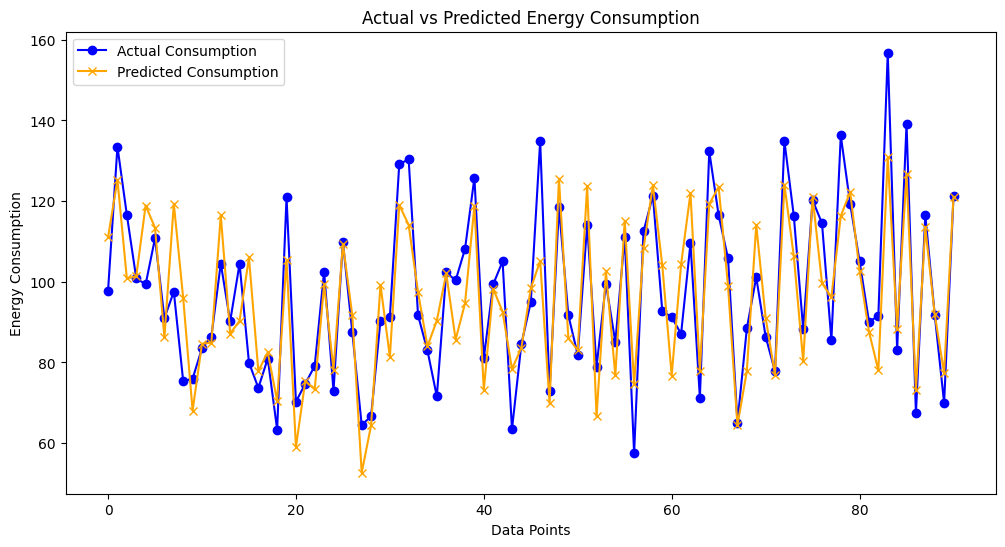

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load Dataset
data = pd.read_csv('new_data.csv')  # Replace with your dataset file path
print(data.head())

# Data Preprocessing
# Drop the 'date' column as it's not directly useful for modeling
if 'date' in data.columns:
    data.drop(columns=['date'], inplace=True)

# Handling Categorical Variables (if any)
label_encoder_month = LabelEncoder()
if 'month_name' in data.columns:
    data['month_name'] = label_encoder_month.fit_transform(data['month_name'])

label_encoder_day = LabelEncoder()
if 'day_type' in data.columns:  # Assume 'day_type' column indicates 'weekday' or 'weekend'
    data['day_type'] = label_encoder_day.fit_transform(data['day_type'])

# Handle Missing Data
# Fill numeric columns with their mean
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)

# Feature Engineering
# Adding Lag Features for Time-Series (if data has date/time column)
if 'consumption' in data.columns:
    data['lag_1'] = data['consumption'].shift(1)
    data['lag_2'] = data['consumption'].shift(2)
    data['lag_7'] = data['consumption'].shift(7)
    data.dropna(inplace=True)  # Drop rows with NaN values after shifting

# Define Features (X) and Target (y)
X = data.drop(columns=['consumption'])  # Features
y = data['consumption']  # Target Variable

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Multiple Models for Comparison
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=15)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}

# Display Model Performance
print("Model Performance:")
for model, metrics in results.items():
    print(f"{model} -> MSE: {metrics['MSE']:.2f}, R²: {metrics['R²']:.2f}")

# Hyperparameter Tuning for Ridge and Lasso
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
lasso = Lasso()

ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

ridge_search.fit(X_train_scaled, y_train)
lasso_search.fit(X_train_scaled, y_train)

# Best Parameters
print(f"Best Ridge Alpha: {ridge_search.best_params_}")
print(f"Best Lasso Alpha: {lasso_search.best_params_}")

# Final Model: Polynomial Ridge Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

ridge_final = Ridge(alpha=ridge_search.best_params_['alpha'])
ridge_final.fit(X_train_poly, y_train)
y_pred_poly = ridge_final.predict(X_test_poly)

# Evaluate Final Model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Ridge Regression -> MSE: {mse_poly:.2f}, R²: {r2_poly:.2f}")

# Visualize Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Consumption', color='blue', marker='o')
plt.plot(y_pred_poly, label='Predicted Consumption', color='orange', marker='x')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Data Points')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
